# This is a tutorial of using spaVAE for enhancing spatial resolutions of mouse olfactory bulb data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Rep9_MOB.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.decoder_layers = [32]
        self.beta = 20
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.enhanced_counts_file = 'enhanced_counts.txt'
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

(236, 2949)
(236, 2)
(49, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=2949, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")


denoised_counts = model.batching_denoise_counts(X=loc, Y=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.denoised_counts_file, denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:36.32831629, NB loss:1.81313169, KLD loss:0.06568255, noise regularization:0.000000
Current kernel scale tensor([20.0008])
Training epoch 2, ELBO:36.20594354, NB loss:1.80251244, KLD loss:0.15569471, noise regularization:0.000000
Current kernel scale tensor([20.0016])
Training epoch 3, ELBO:35.98104424, NB loss:1.79302582, KLD loss:0.12052783, noise regularization:0.000000
Current kernel scale tensor([20.0023])
Training epoch 4, ELBO:35.84769089, NB loss:1.78703867, KLD loss:0.10691755, noise regularization:0.000000
Current kernel scale tensor([20.0031])
Training epoch 5, ELBO:35.75721290, NB loss:1.78284910, KLD loss:0.10023092, noise regularization:0.000000
Current kernel scale tensor([20.0039])
Training epoch 6, ELBO:35.64749823, NB loss:1.77724884, KLD loss:0.10252134, noise regularization:0.000000
Current kernel scale tensor([20.0047])
Training epoch 7, ELBO:35.51789677, NB loss:1.77045799, KLD loss:0.10873689, noise regularization:0.000000
Current 

Training epoch 57, ELBO:31.74086316, NB loss:1.57918010, KLD loss:0.15726113, noise regularization:0.000000
Current kernel scale tensor([20.0473])
Training epoch 58, ELBO:31.75309494, NB loss:1.57967800, KLD loss:0.15953493, noise regularization:0.000000
Current kernel scale tensor([20.0482])
Training epoch 59, ELBO:31.63750654, NB loss:1.57367830, KLD loss:0.16394058, noise regularization:0.000000
Current kernel scale tensor([20.0491])
Training epoch 60, ELBO:31.60962314, NB loss:1.57209694, KLD loss:0.16768435, noise regularization:0.000000
Current kernel scale tensor([20.0501])
Training epoch 61, ELBO:31.48046618, NB loss:1.56548472, KLD loss:0.17077176, noise regularization:0.000000
Current kernel scale tensor([20.0510])
Training epoch 62, ELBO:31.41900436, NB loss:1.56233061, KLD loss:0.17239208, noise regularization:0.000000
Current kernel scale tensor([20.0519])
Training epoch 63, ELBO:31.41842008, NB loss:1.56235304, KLD loss:0.17135927, noise regularization:0.000000
Current ke

Training epoch 113, ELBO:28.61308714, NB loss:1.42063384, KLD loss:0.20041029, noise regularization:0.000000
Current kernel scale tensor([20.1028])
Training epoch 114, ELBO:28.60523773, NB loss:1.42027391, KLD loss:0.19975955, noise regularization:0.000000
Current kernel scale tensor([20.1038])
Training epoch 115, ELBO:28.51456419, NB loss:1.41576528, KLD loss:0.19925869, noise regularization:0.000000
Current kernel scale tensor([20.1048])
Training epoch 116, ELBO:28.50784732, NB loss:1.41549129, KLD loss:0.19802152, noise regularization:0.000000
Current kernel scale tensor([20.1058])
Training epoch 117, ELBO:28.48299506, NB loss:1.41429706, KLD loss:0.19705384, noise regularization:0.000000
Current kernel scale tensor([20.1069])
Training epoch 118, ELBO:28.42463004, NB loss:1.41141264, KLD loss:0.19637730, noise regularization:0.000000
Current kernel scale tensor([20.1079])
Training epoch 119, ELBO:28.33829535, NB loss:1.40711148, KLD loss:0.19606567, noise regularization:0.000000
Cur

Training epoch 169, ELBO:26.99851244, NB loss:1.34000103, KLD loss:0.19849187, noise regularization:0.000000
Current kernel scale tensor([20.1650])
Training epoch 170, ELBO:26.97581724, NB loss:1.33878731, KLD loss:0.20007109, noise regularization:0.000000
Current kernel scale tensor([20.1661])
Training epoch 171, ELBO:26.98264946, NB loss:1.33905236, KLD loss:0.20160226, noise regularization:0.000000
Current kernel scale tensor([20.1672])
Training epoch 172, ELBO:26.96220175, NB loss:1.33798394, KLD loss:0.20252304, noise regularization:0.000000
Current kernel scale tensor([20.1683])
Training epoch 173, ELBO:26.96766538, NB loss:1.33824780, KLD loss:0.20270943, noise regularization:0.000000
Current kernel scale tensor([20.1695])
Training epoch 174, ELBO:26.94643591, NB loss:1.33721488, KLD loss:0.20213836, noise regularization:0.000000
Current kernel scale tensor([20.1706])
Training epoch 175, ELBO:26.92379889, NB loss:1.33617196, KLD loss:0.20035964, noise regularization:0.000000
Cur

Training epoch 225, ELBO:26.49498064, NB loss:1.31495471, KLD loss:0.19588653, noise regularization:0.000000
Current kernel scale tensor([20.2248])
Training epoch 226, ELBO:26.47109438, NB loss:1.31375992, KLD loss:0.19589592, noise regularization:0.000000
Current kernel scale tensor([20.2258])
Training epoch 227, ELBO:26.46803162, NB loss:1.31358766, KLD loss:0.19627848, noise regularization:0.000000
Current kernel scale tensor([20.2268])
Training epoch 228, ELBO:26.44264247, NB loss:1.31230724, KLD loss:0.19649760, noise regularization:0.000000
Current kernel scale tensor([20.2277])
Training epoch 229, ELBO:26.45567178, NB loss:1.31296113, KLD loss:0.19644927, noise regularization:0.000000
Current kernel scale tensor([20.2287])
Training epoch 230, ELBO:26.44836333, NB loss:1.31259815, KLD loss:0.19640042, noise regularization:0.000000
Current kernel scale tensor([20.2297])
Training epoch 231, ELBO:26.43552029, NB loss:1.31195315, KLD loss:0.19645724, noise regularization:0.000000
Cur

Training epoch 281, ELBO:26.27246487, NB loss:1.30388403, KLD loss:0.19478430, noise regularization:0.000000
Current kernel scale tensor([20.2785])
Training epoch 282, ELBO:26.26252821, NB loss:1.30327323, KLD loss:0.19706355, noise regularization:0.000000
Current kernel scale tensor([20.2794])
Training epoch 283, ELBO:26.27168264, NB loss:1.30362548, KLD loss:0.19917302, noise regularization:0.000000
Current kernel scale tensor([20.2804])
Training epoch 284, ELBO:26.22378660, NB loss:1.30115630, KLD loss:0.20066053, noise regularization:0.000000
Current kernel scale tensor([20.2814])
Training epoch 285, ELBO:26.22697990, NB loss:1.30127360, KLD loss:0.20150787, noise regularization:0.000000
Current kernel scale tensor([20.2824])
Training epoch 286, ELBO:26.22095909, NB loss:1.30093002, KLD loss:0.20235862, noise regularization:0.000000
Current kernel scale tensor([20.2833])
Training epoch 287, ELBO:26.25207246, NB loss:1.30248788, KLD loss:0.20231489, noise regularization:0.000000
Cur

Training epoch 338, ELBO:26.08754008, NB loss:1.29465375, KLD loss:0.19446511, noise regularization:0.000000
Current kernel scale tensor([20.3295])
Training epoch 339, ELBO:26.05832348, NB loss:1.29314801, KLD loss:0.19536329, noise regularization:0.000000
Current kernel scale tensor([20.3303])
Training epoch 340, ELBO:26.08131969, NB loss:1.29428941, KLD loss:0.19553147, noise regularization:0.000000
Current kernel scale tensor([20.3312])
Training epoch 341, ELBO:26.10080570, NB loss:1.29528840, KLD loss:0.19503762, noise regularization:0.000000
Current kernel scale tensor([20.3320])
Training epoch 342, ELBO:26.05673893, NB loss:1.29307555, KLD loss:0.19522789, noise regularization:0.000000
Current kernel scale tensor([20.3329])
Training epoch 343, ELBO:26.04989617, NB loss:1.29272218, KLD loss:0.19545262, noise regularization:0.000000
Current kernel scale tensor([20.3338])
Training epoch 344, ELBO:26.06029568, NB loss:1.29326315, KLD loss:0.19503265, noise regularization:0.000000
Cur

Training epoch 395, ELBO:25.94728928, NB loss:1.28756131, KLD loss:0.19606307, noise regularization:0.000000
Current kernel scale tensor([20.3784])
Training epoch 396, ELBO:25.94468903, NB loss:1.28742983, KLD loss:0.19609249, noise regularization:0.000000
Current kernel scale tensor([20.3792])
Training epoch 397, ELBO:25.91956666, NB loss:1.28615755, KLD loss:0.19641558, noise regularization:0.000000
Current kernel scale tensor([20.3800])
Training epoch 398, ELBO:25.92325077, NB loss:1.28632945, KLD loss:0.19666183, noise regularization:0.000000
Current kernel scale tensor([20.3809])
Training epoch 399, ELBO:25.92227537, NB loss:1.28629172, KLD loss:0.19644101, noise regularization:0.000000
Current kernel scale tensor([20.3817])
Training epoch 400, ELBO:25.94544443, NB loss:1.28746435, KLD loss:0.19615733, noise regularization:0.000000
Current kernel scale tensor([20.3825])
Training epoch 401, ELBO:25.93061534, NB loss:1.28674488, KLD loss:0.19571780, noise regularization:0.000000
Cur

Training epoch 452, ELBO:25.81489782, NB loss:1.28106074, KLD loss:0.19368302, noise regularization:0.000000
Current kernel scale tensor([20.4272])
Training epoch 453, ELBO:25.79391597, NB loss:1.28000616, KLD loss:0.19379279, noise regularization:0.000000
Current kernel scale tensor([20.4281])
Training epoch 454, ELBO:25.79387731, NB loss:1.27998335, KLD loss:0.19421036, noise regularization:0.000000
Current kernel scale tensor([20.4289])
Training epoch 455, ELBO:25.82115702, NB loss:1.28134939, KLD loss:0.19416929, noise regularization:0.000000
Current kernel scale tensor([20.4297])
Training epoch 456, ELBO:25.80620838, NB loss:1.28060131, KLD loss:0.19418226, noise regularization:0.000000
Current kernel scale tensor([20.4306])
Training epoch 457, ELBO:25.80788985, NB loss:1.28067794, KLD loss:0.19433111, noise regularization:0.000000
Current kernel scale tensor([20.4314])
Training epoch 458, ELBO:25.81529125, NB loss:1.28105121, KLD loss:0.19426705, noise regularization:0.000000
Cur

Training epoch 508, ELBO:25.71422482, NB loss:1.27601226, KLD loss:0.19397969, noise regularization:0.000000
Current kernel scale tensor([20.4737])
Training epoch 509, ELBO:25.70321359, NB loss:1.27552630, KLD loss:0.19268766, noise regularization:0.000000
Current kernel scale tensor([20.4745])
Training epoch 510, ELBO:25.71007191, NB loss:1.27589238, KLD loss:0.19222430, noise regularization:0.000000
Current kernel scale tensor([20.4753])
Training epoch 511, ELBO:25.69355928, NB loss:1.27508198, KLD loss:0.19191971, noise regularization:0.000000
Current kernel scale tensor([20.4762])
Training epoch 512, ELBO:25.74567383, NB loss:1.27768810, KLD loss:0.19191183, noise regularization:0.000000
Current kernel scale tensor([20.4770])
Training epoch 513, ELBO:25.70976863, NB loss:1.27582597, KLD loss:0.19324926, noise regularization:0.000000
Current kernel scale tensor([20.4778])
Training epoch 514, ELBO:25.73113527, NB loss:1.27679704, KLD loss:0.19519455, noise regularization:0.000000
Cur

Training epoch 566, ELBO:25.60385816, NB loss:1.27042361, KLD loss:0.19538603, noise regularization:0.000000
Current kernel scale tensor([20.5212])
Training epoch 567, ELBO:25.61574287, NB loss:1.27114112, KLD loss:0.19292044, noise regularization:0.000000
Current kernel scale tensor([20.5220])
Training epoch 568, ELBO:25.61590744, NB loss:1.27123788, KLD loss:0.19114988, noise regularization:0.000000
Current kernel scale tensor([20.5228])
Training epoch 569, ELBO:25.59011323, NB loss:1.27000800, KLD loss:0.18995327, noise regularization:0.000000
Current kernel scale tensor([20.5236])
Training epoch 570, ELBO:25.62588293, NB loss:1.27182984, KLD loss:0.18928609, noise regularization:0.000000
Current kernel scale tensor([20.5245])
Training epoch 571, ELBO:25.61792896, NB loss:1.27142578, KLD loss:0.18941342, noise regularization:0.000000
Current kernel scale tensor([20.5253])
Training epoch 572, ELBO:25.61962295, NB loss:1.27143591, KLD loss:0.19090470, noise regularization:0.000000
Cur

Training epoch 625, ELBO:25.50696054, NB loss:1.26551661, KLD loss:0.19662837, noise regularization:0.000000
Current kernel scale tensor([20.5695])
Training epoch 626, ELBO:25.54051124, NB loss:1.26714511, KLD loss:0.19760911, noise regularization:0.000000
Current kernel scale tensor([20.5703])
Training epoch 627, ELBO:25.50772016, NB loss:1.26547671, KLD loss:0.19818601, noise regularization:0.000000
Current kernel scale tensor([20.5712])
Training epoch 628, ELBO:25.52744577, NB loss:1.26645253, KLD loss:0.19839513, noise regularization:0.000000
Current kernel scale tensor([20.5720])
Training epoch 629, ELBO:25.52828710, NB loss:1.26650154, KLD loss:0.19825621, noise regularization:0.000000
Current kernel scale tensor([20.5728])
Training epoch 630, ELBO:25.49296111, NB loss:1.26476293, KLD loss:0.19770249, noise regularization:0.000000
Current kernel scale tensor([20.5736])
Training epoch 631, ELBO:25.51668578, NB loss:1.26601518, KLD loss:0.19638224, noise regularization:0.000000
Cur

Training epoch 682, ELBO:25.42915580, NB loss:1.26158107, KLD loss:0.19753443, noise regularization:0.000000
Current kernel scale tensor([20.6162])
Training epoch 683, ELBO:25.42609414, NB loss:1.26148197, KLD loss:0.19645470, noise regularization:0.000000
Current kernel scale tensor([20.6170])
Training epoch 684, ELBO:25.42651432, NB loss:1.26150404, KLD loss:0.19643354, noise regularization:0.000000
Current kernel scale tensor([20.6179])
Training epoch 685, ELBO:25.41541855, NB loss:1.26093144, KLD loss:0.19678977, noise regularization:0.000000
Current kernel scale tensor([20.6187])
Training epoch 686, ELBO:25.37625409, NB loss:1.25895423, KLD loss:0.19716947, noise regularization:0.000000
Current kernel scale tensor([20.6195])
Training epoch 687, ELBO:25.40157639, NB loss:1.26020827, KLD loss:0.19741089, noise regularization:0.000000
Current kernel scale tensor([20.6203])
Training epoch 688, ELBO:25.41854460, NB loss:1.26107065, KLD loss:0.19713167, noise regularization:0.000000
Cur

Current kernel scale tensor([20.6628])
Training epoch 740, ELBO:25.32922985, NB loss:1.25648301, KLD loss:0.19956959, noise regularization:0.000000
Current kernel scale tensor([20.6636])
Training epoch 741, ELBO:25.35788979, NB loss:1.25786474, KLD loss:0.20059495, noise regularization:0.000000
Current kernel scale tensor([20.6644])
Training epoch 742, ELBO:25.34189230, NB loss:1.25703359, KLD loss:0.20122054, noise regularization:0.000000
Current kernel scale tensor([20.6652])
Training epoch 743, ELBO:25.34355085, NB loss:1.25712586, KLD loss:0.20103369, noise regularization:0.000000
Current kernel scale tensor([20.6660])
Training epoch 744, ELBO:25.33616138, NB loss:1.25677020, KLD loss:0.20075745, noise regularization:0.000000
Current kernel scale tensor([20.6668])
Training epoch 745, ELBO:25.30844301, NB loss:1.25541304, KLD loss:0.20018228, noise regularization:0.000000
Current kernel scale tensor([20.6676])
Training epoch 746, ELBO:25.35374147, NB loss:1.25775082, KLD loss:0.1987

Training epoch 798, ELBO:25.25809425, NB loss:1.25290250, KLD loss:0.20004429, noise regularization:0.000000
Current kernel scale tensor([20.7091])
Training epoch 799, ELBO:25.26861068, NB loss:1.25350361, KLD loss:0.19853855, noise regularization:0.000000
Current kernel scale tensor([20.7099])
Training epoch 800, ELBO:25.26972847, NB loss:1.25362370, KLD loss:0.19725443, noise regularization:0.000000
Current kernel scale tensor([20.7106])
Training epoch 801, ELBO:25.26310876, NB loss:1.25333006, KLD loss:0.19650754, noise regularization:0.000000
Current kernel scale tensor([20.7114])
Training epoch 802, ELBO:25.25386589, NB loss:1.25291419, KLD loss:0.19558211, noise regularization:0.000000
Current kernel scale tensor([20.7122])
Training epoch 803, ELBO:25.25409540, NB loss:1.25293649, KLD loss:0.19536561, noise regularization:0.000000
Current kernel scale tensor([20.7130])
Training epoch 804, ELBO:25.27301685, NB loss:1.25387635, KLD loss:0.19548991, noise regularization:0.000000
Cur

Training epoch 854, ELBO:25.19474409, NB loss:1.24985848, KLD loss:0.19757456, noise regularization:0.000000
Current kernel scale tensor([20.7538])
Training epoch 855, ELBO:25.19251798, NB loss:1.24970244, KLD loss:0.19846921, noise regularization:0.000000
Current kernel scale tensor([20.7546])
Training epoch 856, ELBO:25.15523873, NB loss:1.24782042, KLD loss:0.19883029, noise regularization:0.000000
Current kernel scale tensor([20.7554])
Training epoch 857, ELBO:25.19470629, NB loss:1.24982452, KLD loss:0.19821595, noise regularization:0.000000
Current kernel scale tensor([20.7562])
Training epoch 858, ELBO:25.18478811, NB loss:1.24936450, KLD loss:0.19749805, noise regularization:0.000000
Current kernel scale tensor([20.7570])
Training epoch 859, ELBO:25.18016688, NB loss:1.24916627, KLD loss:0.19684154, noise regularization:0.000000
Current kernel scale tensor([20.7578])
Training epoch 860, ELBO:25.17568878, NB loss:1.24899693, KLD loss:0.19575027, noise regularization:0.000000
Cur

Training epoch 910, ELBO:25.11533974, NB loss:1.24609260, KLD loss:0.19348768, noise regularization:0.000000
Current kernel scale tensor([20.7986])
Training epoch 911, ELBO:25.12161617, NB loss:1.24640672, KLD loss:0.19348183, noise regularization:0.000000
Current kernel scale tensor([20.7994])
Training epoch 912, ELBO:25.12862008, NB loss:1.24674150, KLD loss:0.19379001, noise regularization:0.000000
Current kernel scale tensor([20.8001])
Training epoch 913, ELBO:25.12186641, NB loss:1.24638147, KLD loss:0.19423705, noise regularization:0.000000
Current kernel scale tensor([20.8009])
Training epoch 914, ELBO:25.09296061, NB loss:1.24490278, KLD loss:0.19490509, noise regularization:0.000000
Current kernel scale tensor([20.8017])
Training epoch 915, ELBO:25.08900146, NB loss:1.24469065, KLD loss:0.19518838, noise regularization:0.000000
Current kernel scale tensor([20.8025])
Training epoch 916, ELBO:25.08917931, NB loss:1.24468805, KLD loss:0.19541839, noise regularization:0.000000
Cur

Training epoch 966, ELBO:25.07249098, NB loss:1.24394703, KLD loss:0.19355030, noise regularization:0.000000
Current kernel scale tensor([20.8435])
Training epoch 967, ELBO:25.05498811, NB loss:1.24309516, KLD loss:0.19308491, noise regularization:0.000000
Current kernel scale tensor([20.8443])
Training epoch 968, ELBO:25.03703833, NB loss:1.24216863, KLD loss:0.19366567, noise regularization:0.000000
Current kernel scale tensor([20.8451])
Training epoch 969, ELBO:25.06251633, NB loss:1.24339724, KLD loss:0.19457143, noise regularization:0.000000
Current kernel scale tensor([20.8459])
Training epoch 970, ELBO:25.02503319, NB loss:1.24145887, KLD loss:0.19585583, noise regularization:0.000000
Current kernel scale tensor([20.8467])
Training epoch 971, ELBO:25.05232274, NB loss:1.24279985, KLD loss:0.19632568, noise regularization:0.000000
Current kernel scale tensor([20.8475])
Training epoch 972, ELBO:25.02375068, NB loss:1.24134865, KLD loss:0.19677762, noise regularization:0.000000
Cur

Training epoch 1023, ELBO:25.00019372, NB loss:1.24017744, KLD loss:0.19664497, noise regularization:0.000000
Current kernel scale tensor([20.8881])
Training epoch 1024, ELBO:25.01535598, NB loss:1.24096225, KLD loss:0.19611099, noise regularization:0.000000
Current kernel scale tensor([20.8889])
Training epoch 1025, ELBO:24.98583304, NB loss:1.23950273, KLD loss:0.19577837, noise regularization:0.000000
Current kernel scale tensor([20.8897])
Training epoch 1026, ELBO:24.97199898, NB loss:1.23882939, KLD loss:0.19541119, noise regularization:0.000000
Current kernel scale tensor([20.8905])
Training epoch 1027, ELBO:24.98487319, NB loss:1.23949727, KLD loss:0.19492787, noise regularization:0.000000
Current kernel scale tensor([20.8913])
Training epoch 1028, ELBO:24.96242608, NB loss:1.23839364, KLD loss:0.19455330, noise regularization:0.000000
Current kernel scale tensor([20.8920])
Training epoch 1029, ELBO:24.96397766, NB loss:1.23847429, KLD loss:0.19449196, noise regularization:0.000

Training epoch 1080, ELBO:24.91565932, NB loss:1.23628246, KLD loss:0.19001020, noise regularization:0.000000
Current kernel scale tensor([20.9319])
Training epoch 1081, ELBO:24.94300004, NB loss:1.23761380, KLD loss:0.19072403, noise regularization:0.000000
Current kernel scale tensor([20.9327])
Training epoch 1082, ELBO:24.90504708, NB loss:1.23565466, KLD loss:0.19195392, noise regularization:0.000000
Current kernel scale tensor([20.9335])
Training epoch 1083, ELBO:24.92586905, NB loss:1.23664727, KLD loss:0.19292372, noise regularization:0.000000
Current kernel scale tensor([20.9343])
Training epoch 1084, ELBO:24.89085882, NB loss:1.23487924, KLD loss:0.19327410, noise regularization:0.000000
Current kernel scale tensor([20.9351])
Training epoch 1085, ELBO:24.89790397, NB loss:1.23524317, KLD loss:0.19304052, noise regularization:0.000000
Current kernel scale tensor([20.9358])
Training epoch 1086, ELBO:24.90969379, NB loss:1.23585906, KLD loss:0.19251252, noise regularization:0.000

Training epoch 1137, ELBO:24.86249758, NB loss:1.23364425, KLD loss:0.18961257, noise regularization:0.000000
Current kernel scale tensor([20.9750])
Training epoch 1138, ELBO:24.84844145, NB loss:1.23302416, KLD loss:0.18795829, noise regularization:0.000000
Current kernel scale tensor([20.9758])
Training epoch 1139, ELBO:24.86099660, NB loss:1.23371446, KLD loss:0.18670746, noise regularization:0.000000
Current kernel scale tensor([20.9765])
Training epoch 1140, ELBO:24.85054548, NB loss:1.23320004, KLD loss:0.18654467, noise regularization:0.000000
Current kernel scale tensor([20.9773])
Training epoch 1141, ELBO:24.84203939, NB loss:1.23272752, KLD loss:0.18748901, noise regularization:0.000000
Current kernel scale tensor([20.9781])
Training epoch 1142, ELBO:24.86086721, NB loss:1.23357953, KLD loss:0.18927661, noise regularization:0.000000
Current kernel scale tensor([20.9789])
Training epoch 1143, ELBO:24.85447358, NB loss:1.23317321, KLD loss:0.19100947, noise regularization:0.000

Training epoch 1193, ELBO:24.82356018, NB loss:1.23162074, KLD loss:0.19114529, noise regularization:0.000000
Current kernel scale tensor([21.0185])
Training epoch 1194, ELBO:24.77835240, NB loss:1.22927216, KLD loss:0.19290918, noise regularization:0.000000
Current kernel scale tensor([21.0193])
Training epoch 1195, ELBO:24.79395635, NB loss:1.23001709, KLD loss:0.19361465, noise regularization:0.000000
Current kernel scale tensor([21.0201])
Training epoch 1196, ELBO:24.80575649, NB loss:1.23059598, KLD loss:0.19383684, noise regularization:0.000000
Current kernel scale tensor([21.0209])
Training epoch 1197, ELBO:24.78269834, NB loss:1.22942675, KLD loss:0.19416334, noise regularization:0.000000
Current kernel scale tensor([21.0217])
Training epoch 1198, ELBO:24.78313847, NB loss:1.22946388, KLD loss:0.19386092, noise regularization:0.000000
Current kernel scale tensor([21.0225])
Training epoch 1199, ELBO:24.78072784, NB loss:1.22936532, KLD loss:0.19342135, noise regularization:0.000

Training epoch 1250, ELBO:24.72624093, NB loss:1.22675896, KLD loss:0.19106173, noise regularization:0.000000
Current kernel scale tensor([21.0620])
Training epoch 1251, ELBO:24.71182734, NB loss:1.22608099, KLD loss:0.19020758, noise regularization:0.000000
Current kernel scale tensor([21.0627])
Training epoch 1252, ELBO:24.71469574, NB loss:1.22628723, KLD loss:0.18895108, noise regularization:0.000000
Current kernel scale tensor([21.0634])
Training epoch 1253, ELBO:24.74379950, NB loss:1.22782641, KLD loss:0.18727135, noise regularization:0.000000
Current kernel scale tensor([21.0641])
Training epoch 1254, ELBO:24.70932284, NB loss:1.22614481, KLD loss:0.18642669, noise regularization:0.000000
Current kernel scale tensor([21.0648])
Training epoch 1255, ELBO:24.70940490, NB loss:1.22619226, KLD loss:0.18555978, noise regularization:0.000000
Current kernel scale tensor([21.0655])
Training epoch 1256, ELBO:24.73794579, NB loss:1.22765167, KLD loss:0.18491239, noise regularization:0.000

Training epoch 1306, ELBO:24.66983722, NB loss:1.22429809, KLD loss:0.18387542, noise regularization:0.000000
Current kernel scale tensor([21.1035])
Training epoch 1307, ELBO:24.66977447, NB loss:1.22430186, KLD loss:0.18373731, noise regularization:0.000000
Current kernel scale tensor([21.1042])
Training epoch 1308, ELBO:24.69366898, NB loss:1.22551897, KLD loss:0.18328958, noise regularization:0.000000
Current kernel scale tensor([21.1050])
Training epoch 1309, ELBO:24.68160102, NB loss:1.22490964, KLD loss:0.18340813, noise regularization:0.000000
Current kernel scale tensor([21.1058])
Training epoch 1310, ELBO:24.68325646, NB loss:1.22496614, KLD loss:0.18393363, noise regularization:0.000000
Current kernel scale tensor([21.1065])
Training epoch 1311, ELBO:24.71183853, NB loss:1.22636789, KLD loss:0.18448068, noise regularization:0.000000
Current kernel scale tensor([21.1074])
Training epoch 1312, ELBO:24.69001867, NB loss:1.22519592, KLD loss:0.18610019, noise regularization:0.000

Training epoch 1361, ELBO:24.63866652, NB loss:1.22241892, KLD loss:0.19028818, noise regularization:0.000000
Current kernel scale tensor([21.1455])
Training epoch 1362, ELBO:24.62229399, NB loss:1.22164692, KLD loss:0.18935563, noise regularization:0.000000
Current kernel scale tensor([21.1463])
Training epoch 1363, ELBO:24.62525669, NB loss:1.22186664, KLD loss:0.18792395, noise regularization:0.000000
Current kernel scale tensor([21.1470])
Training epoch 1364, ELBO:24.59487097, NB loss:1.22042943, KLD loss:0.18628230, noise regularization:0.000000
Current kernel scale tensor([21.1477])
Training epoch 1365, ELBO:24.62096626, NB loss:1.22185541, KLD loss:0.18385813, noise regularization:0.000000
Current kernel scale tensor([21.1485])
Training epoch 1366, ELBO:24.61366027, NB loss:1.22159773, KLD loss:0.18170574, noise regularization:0.000000
Current kernel scale tensor([21.1492])
Training epoch 1367, ELBO:24.61245129, NB loss:1.22161625, KLD loss:0.18012637, noise regularization:0.000

Training epoch 1416, ELBO:24.59525728, NB loss:1.22047746, KLD loss:0.18570811, noise regularization:0.000000
Current kernel scale tensor([21.1870])
Training epoch 1417, ELBO:24.57716109, NB loss:1.21952772, KLD loss:0.18660664, noise regularization:0.000000
Current kernel scale tensor([21.1877])
Training epoch 1418, ELBO:24.58655735, NB loss:1.21999399, KLD loss:0.18667765, noise regularization:0.000000
Current kernel scale tensor([21.1885])
Training epoch 1419, ELBO:24.56565034, NB loss:1.21891878, KLD loss:0.18727469, noise regularization:0.000000
Current kernel scale tensor([21.1893])
Training epoch 1420, ELBO:24.59001374, NB loss:1.22010377, KLD loss:0.18793834, noise regularization:0.000000
Current kernel scale tensor([21.1900])
Training epoch 1421, ELBO:24.55362516, NB loss:1.21827098, KLD loss:0.18820559, noise regularization:0.000000
Current kernel scale tensor([21.1908])
Training epoch 1422, ELBO:24.60176416, NB loss:1.22069733, KLD loss:0.18781761, noise regularization:0.000

Training epoch 1471, ELBO:24.53685531, NB loss:1.21775441, KLD loss:0.18176702, noise regularization:0.000000
Current kernel scale tensor([21.2283])
Training epoch 1472, ELBO:24.53235670, NB loss:1.21752447, KLD loss:0.18186737, noise regularization:0.000000
Current kernel scale tensor([21.2290])
Training epoch 1473, ELBO:24.53164488, NB loss:1.21747355, KLD loss:0.18217390, noise regularization:0.000000
Current kernel scale tensor([21.2298])
Training epoch 1474, ELBO:24.55190861, NB loss:1.21847078, KLD loss:0.18249304, noise regularization:0.000000
Current kernel scale tensor([21.2305])
Training epoch 1475, ELBO:24.51396656, NB loss:1.21655007, KLD loss:0.18296519, noise regularization:0.000000
Current kernel scale tensor([21.2313])
Training epoch 1476, ELBO:24.52325789, NB loss:1.21700143, KLD loss:0.18322937, noise regularization:0.000000
Current kernel scale tensor([21.2320])
Training epoch 1477, ELBO:24.55489192, NB loss:1.21855952, KLD loss:0.18370157, noise regularization:0.000

Training epoch 1527, ELBO:24.47759478, NB loss:1.21455941, KLD loss:0.18640666, noise regularization:0.000000
Current kernel scale tensor([21.2712])
Training epoch 1528, ELBO:24.52040033, NB loss:1.21672023, KLD loss:0.18599571, noise regularization:0.000000
Current kernel scale tensor([21.2720])
Training epoch 1529, ELBO:24.48500175, NB loss:1.21493364, KLD loss:0.18632887, noise regularization:0.000000
Current kernel scale tensor([21.2728])
Training epoch 1530, ELBO:24.50774529, NB loss:1.21602838, KLD loss:0.18717777, noise regularization:0.000000
Current kernel scale tensor([21.2736])
Training epoch 1531, ELBO:24.50108754, NB loss:1.21561936, KLD loss:0.18870038, noise regularization:0.000000
Current kernel scale tensor([21.2744])
Training epoch 1532, ELBO:24.50321141, NB loss:1.21564419, KLD loss:0.19032767, noise regularization:0.000000
Current kernel scale tensor([21.2752])
Training epoch 1533, ELBO:24.47804332, NB loss:1.21433415, KLD loss:0.19136031, noise regularization:0.000

Training epoch 1584, ELBO:24.46186303, NB loss:1.21376064, KLD loss:0.18665031, noise regularization:0.000000
Current kernel scale tensor([21.3135])
Training epoch 1585, ELBO:24.44791913, NB loss:1.21302037, KLD loss:0.18751182, noise regularization:0.000000
Current kernel scale tensor([21.3143])
Training epoch 1586, ELBO:24.43770957, NB loss:1.21249716, KLD loss:0.18776642, noise regularization:0.000000
Current kernel scale tensor([21.3150])
Training epoch 1587, ELBO:24.44136167, NB loss:1.21272657, KLD loss:0.18683017, noise regularization:0.000000
Current kernel scale tensor([21.3158])
Training epoch 1588, ELBO:24.43658853, NB loss:1.21256863, KLD loss:0.18521591, noise regularization:0.000000
Current kernel scale tensor([21.3165])
Training epoch 1589, ELBO:24.44224223, NB loss:1.21295864, KLD loss:0.18306941, noise regularization:0.000000
Current kernel scale tensor([21.3173])
Training epoch 1590, ELBO:24.43684703, NB loss:1.21278410, KLD loss:0.18116493, noise regularization:0.000

Training epoch 1640, ELBO:24.41397068, NB loss:1.21178908, KLD loss:0.17818899, noise regularization:0.000000
Current kernel scale tensor([21.3555])
Training epoch 1641, ELBO:24.37416066, NB loss:1.20978535, KLD loss:0.17845376, noise regularization:0.000000
Current kernel scale tensor([21.3562])
Training epoch 1642, ELBO:24.42056012, NB loss:1.21209149, KLD loss:0.17873029, noise regularization:0.000000
Current kernel scale tensor([21.3570])
Training epoch 1643, ELBO:24.38787026, NB loss:1.21038670, KLD loss:0.18013632, noise regularization:0.000000
Current kernel scale tensor([21.3578])
Training epoch 1644, ELBO:24.41620546, NB loss:1.21172085, KLD loss:0.18178837, noise regularization:0.000000
Current kernel scale tensor([21.3586])
Training epoch 1645, ELBO:24.38628810, NB loss:1.21015138, KLD loss:0.18326056, noise regularization:0.000000
Current kernel scale tensor([21.3594])
Training epoch 1646, ELBO:24.43164964, NB loss:1.21237546, KLD loss:0.18414049, noise regularization:0.000

Training epoch 1697, ELBO:24.36327584, NB loss:1.20923009, KLD loss:0.17867394, noise regularization:0.000000
Current kernel scale tensor([21.3989])
Training epoch 1698, ELBO:24.39181443, NB loss:1.21066503, KLD loss:0.17851393, noise regularization:0.000000
Current kernel scale tensor([21.3997])
Training epoch 1699, ELBO:24.37152134, NB loss:1.20962563, KLD loss:0.17900868, noise regularization:0.000000
Current kernel scale tensor([21.4005])
Training epoch 1700, ELBO:24.35637359, NB loss:1.20883705, KLD loss:0.17963254, noise regularization:0.000000
Current kernel scale tensor([21.4012])
Training epoch 1701, ELBO:24.39810256, NB loss:1.21087834, KLD loss:0.18053577, noise regularization:0.000000
Current kernel scale tensor([21.4020])
Training epoch 1702, ELBO:24.33571152, NB loss:1.20767760, KLD loss:0.18215953, noise regularization:0.000000
Current kernel scale tensor([21.4028])
Training epoch 1703, ELBO:24.35334118, NB loss:1.20851385, KLD loss:0.18306411, noise regularization:0.000

Training epoch 1752, ELBO:24.32072363, NB loss:1.20697669, KLD loss:0.18118978, noise regularization:0.000000
Current kernel scale tensor([21.4399])
Training epoch 1753, ELBO:24.34224425, NB loss:1.20810743, KLD loss:0.18009571, noise regularization:0.000000
Current kernel scale tensor([21.4407])
Training epoch 1754, ELBO:24.30639736, NB loss:1.20631686, KLD loss:0.18006011, noise regularization:0.000000
Current kernel scale tensor([21.4414])
Training epoch 1755, ELBO:24.32771483, NB loss:1.20738022, KLD loss:0.18011051, noise regularization:0.000000
Current kernel scale tensor([21.4422])
Training epoch 1756, ELBO:24.31860623, NB loss:1.20689774, KLD loss:0.18065151, noise regularization:0.000000
Current kernel scale tensor([21.4429])
Training epoch 1757, ELBO:24.32737903, NB loss:1.20731155, KLD loss:0.18114802, noise regularization:0.000000
Current kernel scale tensor([21.4437])
Training epoch 1758, ELBO:24.32581490, NB loss:1.20719584, KLD loss:0.18189819, noise regularization:0.000

Training epoch 1810, ELBO:24.27490139, NB loss:1.20456068, KLD loss:0.18368781, noise regularization:0.000000
Current kernel scale tensor([21.4843])
Training epoch 1811, ELBO:24.30707212, NB loss:1.20617347, KLD loss:0.18360281, noise regularization:0.000000
Current kernel scale tensor([21.4850])
Training epoch 1812, ELBO:24.28818198, NB loss:1.20518994, KLD loss:0.18438328, noise regularization:0.000000
Current kernel scale tensor([21.4858])
Training epoch 1813, ELBO:24.28782480, NB loss:1.20515443, KLD loss:0.18473630, noise regularization:0.000000
Current kernel scale tensor([21.4865])
Training epoch 1814, ELBO:24.26488125, NB loss:1.20399880, KLD loss:0.18490527, noise regularization:0.000000
Current kernel scale tensor([21.4872])
Training epoch 1815, ELBO:24.30483383, NB loss:1.20605702, KLD loss:0.18369344, noise regularization:0.000000
Current kernel scale tensor([21.4880])
Training epoch 1816, ELBO:24.29586005, NB loss:1.20565751, KLD loss:0.18270990, noise regularization:0.000

Training epoch 1865, ELBO:24.26091375, NB loss:1.20366135, KLD loss:0.18768670, noise regularization:0.000000
Current kernel scale tensor([21.5263])
Training epoch 1866, ELBO:24.26634641, NB loss:1.20397967, KLD loss:0.18675295, noise regularization:0.000000
Current kernel scale tensor([21.5271])
Training epoch 1867, ELBO:24.24887184, NB loss:1.20316242, KLD loss:0.18562340, noise regularization:0.000000
Current kernel scale tensor([21.5279])
Training epoch 1868, ELBO:24.25000357, NB loss:1.20327655, KLD loss:0.18447250, noise regularization:0.000000
Current kernel scale tensor([21.5286])
Training epoch 1869, ELBO:24.27201841, NB loss:1.20440437, KLD loss:0.18393094, noise regularization:0.000000
Current kernel scale tensor([21.5294])
Training epoch 1870, ELBO:24.23658857, NB loss:1.20264066, KLD loss:0.18377546, noise regularization:0.000000
Current kernel scale tensor([21.5301])
Training epoch 1871, ELBO:24.24799328, NB loss:1.20322004, KLD loss:0.18359257, noise regularization:0.000

Training epoch 1921, ELBO:24.21959775, NB loss:1.20163992, KLD loss:0.18679932, noise regularization:0.000000
Current kernel scale tensor([21.5685])
Training epoch 1922, ELBO:24.22600390, NB loss:1.20194412, KLD loss:0.18712150, noise regularization:0.000000
Current kernel scale tensor([21.5693])
Training epoch 1923, ELBO:24.20740822, NB loss:1.20102782, KLD loss:0.18685189, noise regularization:0.000000
Current kernel scale tensor([21.5701])
Training epoch 1924, ELBO:24.21741337, NB loss:1.20158705, KLD loss:0.18567237, noise regularization:0.000000
Current kernel scale tensor([21.5708])
Training epoch 1925, ELBO:24.22958109, NB loss:1.20222887, KLD loss:0.18500364, noise regularization:0.000000
Current kernel scale tensor([21.5715])
Training epoch 1926, ELBO:24.22260648, NB loss:1.20192642, KLD loss:0.18407814, noise regularization:0.000000
Current kernel scale tensor([21.5723])
Training epoch 1927, ELBO:24.21561964, NB loss:1.20164252, KLD loss:0.18276934, noise regularization:0.000

Training epoch 1977, ELBO:24.19103801, NB loss:1.20047948, KLD loss:0.18144850, noise regularization:0.000000
Current kernel scale tensor([21.6112])
Training epoch 1978, ELBO:24.17247550, NB loss:1.19954951, KLD loss:0.18148529, noise regularization:0.000000
Current kernel scale tensor([21.6120])
Training epoch 1979, ELBO:24.19203175, NB loss:1.20056225, KLD loss:0.18078671, noise regularization:0.000000
Current kernel scale tensor([21.6128])
Training epoch 1980, ELBO:24.17285280, NB loss:1.19964415, KLD loss:0.17996986, noise regularization:0.000000
Current kernel scale tensor([21.6135])
Training epoch 1981, ELBO:24.18500764, NB loss:1.20029581, KLD loss:0.17909146, noise regularization:0.000000
Current kernel scale tensor([21.6143])
Training epoch 1982, ELBO:24.22135001, NB loss:1.20212531, KLD loss:0.17884379, noise regularization:0.000000
Current kernel scale tensor([21.6151])
Training epoch 1983, ELBO:24.17831262, NB loss:1.19993063, KLD loss:0.17970008, noise regularization:0.000

Enhancing spatial resolutions

In [5]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2).fit(loc)
nearest_dist = neigh.kneighbors(loc, n_neighbors=2)[0]
small_distance = np.median(nearest_dist[:,1])/4
loc_new1 = np.empty_like(loc)
loc_new2 = np.empty_like(loc)
loc_new3 = np.empty_like(loc)
loc_new4 = np.empty_like(loc)
loc_new1[:] = loc
loc_new2[:] = loc
loc_new3[:] = loc
loc_new4[:] = loc
loc_new1[:,0] = loc_new1[:,0] - small_distance
loc_new1[:,1] = loc_new1[:,1] + small_distance
loc_new2[:,0] = loc_new2[:,0] + small_distance
loc_new2[:,1] = loc_new2[:,1] + small_distance
loc_new3[:,0] = loc_new3[:,0] - small_distance
loc_new3[:,1] = loc_new3[:,1] - small_distance
loc_new4[:,0] = loc_new4[:,0] + small_distance
loc_new4[:,1] = loc_new4[:,1] - small_distance
loc_enhance = np.concatenate((loc_new1, loc_new2, loc_new3, loc_new4, loc), axis=0)

_, enhanced_counts = model.batching_predict_samples(X_test=loc_enhance, X_train=loc, Y_train=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.data_file[:-3]+"_"+args.enhanced_counts_file, enhanced_counts, delimiter=",")
np.savetxt(args.data_file[:-3]+"_enhanced_loc.txt", loc_enhance, delimiter=",")

Plot enhanced counts in R and ggplot2.

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(scater)
library(repr)
options(repr.plot.width=16, repr.plot.height=6)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

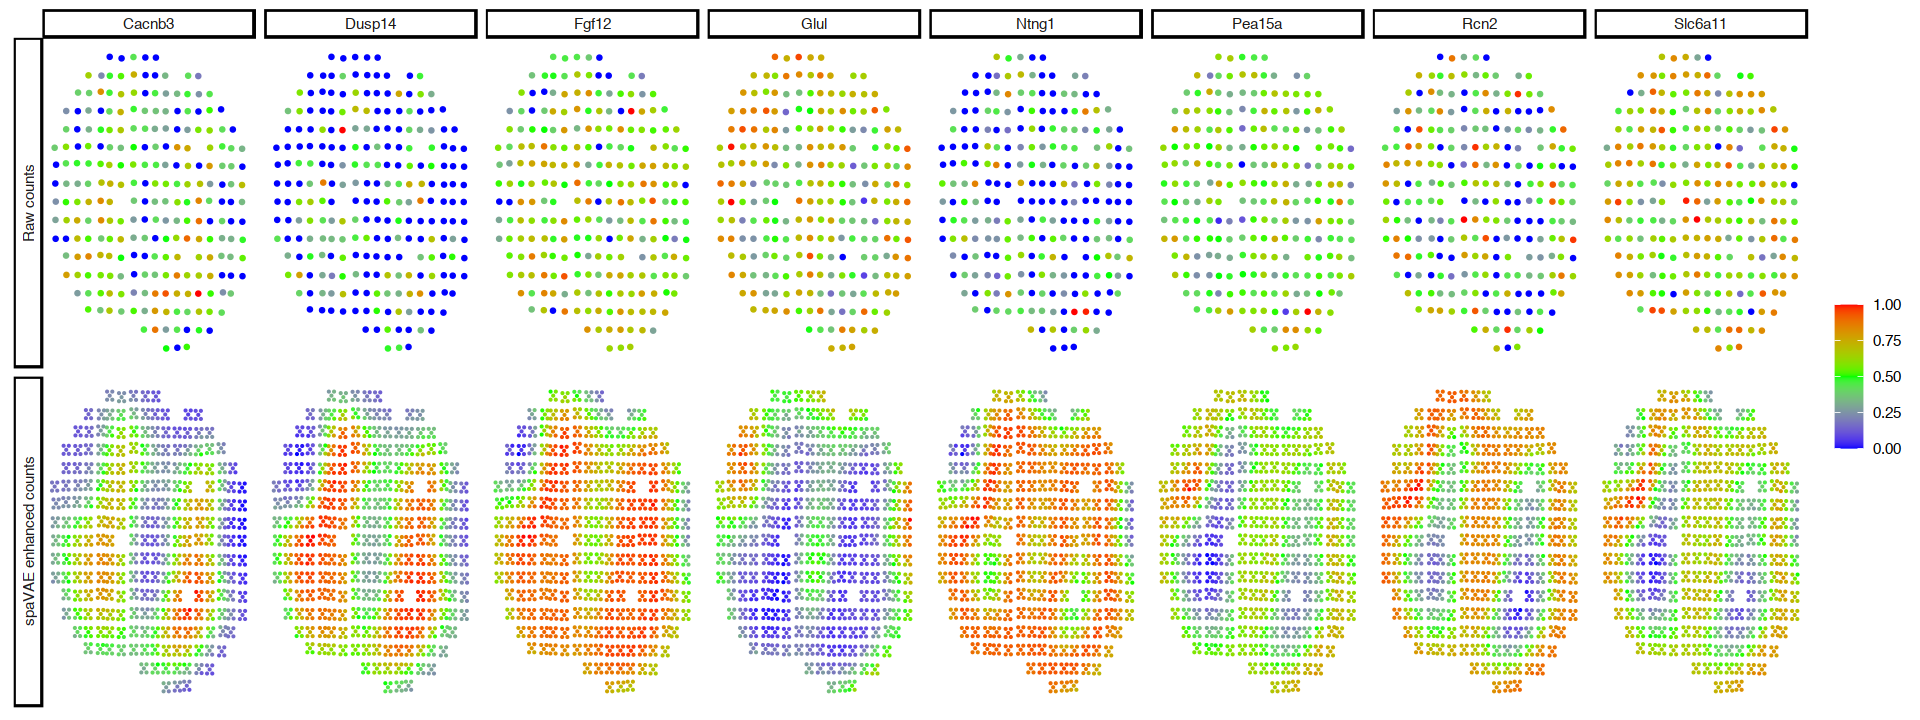

In [2]:
denoise.counts <- read.table("Rep9_MOB_enhanced_counts.txt", sep=",")
genename <- h5read("Rep9_MOB.h5", "gene")
colnames(denoise.counts) <- genename

log.denoise.counts <- log(denoise.counts)
log.denoise.counts <- apply(log.denoise.counts, 2, function(z) scales::rescale(z, to=c(0,1)))

pos <- read.table("Rep9_MOB_enhanced_loc.txt", sep=",")

enhanced.dat <- data.frame(exp=c(log.denoise.counts[, "Cacnb3"], log.denoise.counts[, "Dusp14"], 
                               log.denoise.counts[, "Glul"], log.denoise.counts[, "Rcn2"],
                               log.denoise.counts[, "Ntng1"], log.denoise.counts[, "Pea15a"],
                               log.denoise.counts[, "Fgf12"], log.denoise.counts[, "Slc6a11"]),
                         gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(pos)),
                         x=rep(pos[,1], 8), y=rep(pos[,2], 8), data="spaVAE enhanced counts")

origin.pos <- t(h5read("Rep9_MOB.h5", "pos"))
origin_pos_x <- scales::rescale(origin.pos[,1], to=c(0,1))*20
origin_pos_y <- scales::rescale(origin.pos[,2], to=c(0,1))*20
origin.pos <- data.frame(V1=origin_pos_x, V2=origin_pos_y)
raw.counts <- h5read("Rep9_MOB.h5", "X")
sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- genename
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1)))

origin.dat <- data.frame(exp=c(lograwcounts[, "Cacnb3"], lograwcounts[, "Dusp14"], 
                             lograwcounts[, "Glul"], lograwcounts[, "Rcn2"],
                             lograwcounts[, "Ntng1"], lograwcounts[, "Pea15a"],
                             lograwcounts[, "Fgf12"], lograwcounts[, "Slc6a11"]),
                       gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(origin.pos)),
                       x=rep(origin.pos[,1], 8), y=rep(origin.pos[,2], 8), data="Raw counts")

dat <- rbind(enhanced.dat, origin.dat)
size_vector <- c("Raw counts"=0.8, "spaVAE enhanced counts"=0.11)

ggplot(dat, aes(x=x, y=y, color=exp, size=data)) + geom_point() +
scale_size_manual(values=size_vector, guide = "none") +
facet_grid(data~gene, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
theme_classic() +
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank())